<h1 style="text-align: center; color: #E30613;"><b><i>Annotation Automatique avec VADER</i></b></h1>

<p style="text-align: justify;">
Ce notebook présente une solution complète pour l'annotation automatique des sentiments à l'aide de l'outil <b>VADER (Valence Aware Dictionary and sEntiment Reasoner)</b>.
L'objectif est de traiter des commentaires textuels, d'analyser leurs sentiments (positif, négatif ou neutre) et d'évaluer les performances du modèle.
</p>

<h3>🔍 Étapes Principales :</h3>
<ol>
    <li><b>Chargement des Données :</b> Importation des commentaires et du lexique personnalisé.</li>
    <li><b>Préparation des Modèles NLP :</b> Configuration des modèles linguistiques pour le français et l'anglais.</li>
    <li><b>Personnalisation de VADER :</b> Intégration d'un lexique personnalisé et gestion des bigrams.</li>
    <li><b>Annotation des Sentiments :</b> Analyse des sentiments des commentaires en utilisant VADER.</li>
    <li><b>Évaluation des Résultats :</b> Calcul des métriques de performance et génération de la matrice de confusion.</li>
    <li><b>Enregistrement des Résultats :</b> Sauvegarde des annotations et des métriques dans des fichiers.</li>
</ol>

<p style="text-align: justify;">
Ce workflow est conçu pour être extensible et adaptable à différents jeux de données et langues.
Il utilise des bibliothèques populaires telles que <b>spaCy</b>, <b>nltk</b>.
</p>

## <span style="color: #28A745;">**Bibiliothèques nécessaires**</span>

In [1]:
%pip install -q nltk vaderSentiment spacy tqdm arabic-reshaper python-bidi

# Télécharger les modèles linguistiques de spaCy pour le français et l'anglais
import spacy

spacy.cli.download("fr_core_news_sm")  # Modèle pour le français
spacy.cli.download("en_core_web_sm")  # Modèle pour l'anglais

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 18.7 MB/s eta 0:00:00
✔ Download and installation successful
Yo

In [2]:
import pandas as pd
import os
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des Modèles NLP
import nltk
nltk.download("punkt")
nlp_fr = spacy.load("fr_core_news_sm")  # Modèle français
nlp_en = spacy.load("en_core_web_sm")   # Modèle anglais

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## <span style="color: #E30613;">**1. Chargement des Données**</span>

In [3]:
# Charger le lexique et les commentaires
comments_path = "/content/Results/Comments_clean.csv"
lexicon_xlsx_path = "/content/data/Costum_lexicon.xlsx"

# Lire les fichiers
comments_df = pd.read_csv(comments_path)
df_lexicon = pd.read_excel(lexicon_xlsx_path)

# Vérifier les colonnes
if "Sentiments" not in comments_df.columns:
    raise ValueError("La colonne 'Sentiments' est absente.")

# Charger le lexique personnalisé
custom_lexicon = {}
for _, row in df_lexicon.iterrows():
    word, score = row[0], row[1]  # Suppose que la 1ère colonne est le mot et la 2ème le score
    custom_lexicon[word] = float(score)

print("✅ Lexique personnalisé chargé avec succès !")

✅ Lexique personnalisé chargé avec succès !


<ipython-input-3-6011ab0ee51b>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word, score = row[0], row[1]  # Suppose que la 1ère colonne est le mot et la 2ème le score


## <span style="color: #E30613;">**2. Personnalisation de VADER avec bigrams**</span>

In [4]:
# Générer les bigrams et les ajouter au lexique
bigram_lexicon = {}
for phrase in custom_lexicon.keys():
    tokens = phrase.split()  # Séparer en mots
    if len(tokens) > 1:  # Si c'est un bigramme
        bigram_lexicon["_".join(tokens)] = custom_lexicon[phrase]  # Ajouter au lexique sous forme "mot1_mot2"

# Fusionner les deux lexiques
custom_lexicon.update(bigram_lexicon)

# Initialiser VADER avec le lexique personnalisé
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon.update(custom_lexicon)

## <span style="color: #E30613;">**3. Fonction de Tokenization (inclut les bigrams)**</span>

In [5]:
def tokenize_text(text, lang="fr"):
    """Tokenisation en mots et en bigrammes pour capturer le contexte."""
    if lang == "fr":
        doc = nlp_fr(text)
    else:
        doc = nlp_en(text)

    tokens = [token.text.lower() for token in doc if not token.is_punct]
    bigrams = ["_".join(bigram) for bigram in ngrams(tokens, 2)]  # Convertir les bigrams en format "mot1_mot2"

    return tokens + bigrams

print("✅ Lexique mis à jour avec les bigrammes !")

✅ Lexique mis à jour avec les bigrammes !


## <span style="color: #E30613;">**4. Fonction d'Annotation avec VADER**</span>

In [6]:
def analyze_sentiment(comment):
    """Analyse le sentiment d'un commentaire avec VADER en tenant compte des bigrams."""
    if not isinstance(comment, str) or comment.strip() == "":
        return "Neutre"

    tokens = tokenize_text(comment)  # Tokenisation en mots et bigrams
    modified_comment = " ".join(tokens)  # Reconstruire la phrase avec bigrams

    scores = analyzer.polarity_scores(modified_comment)
    if scores["compound"] >= 0.05:
        return "Positif"
    elif scores["compound"] <= -0.05:
        return "Negatif"
    else:
        return "Neutre"

## <span style="color: #E30613;">**5. Application du Modèle VADER**</span>

In [7]:
print("🔄 Annotation des sentiments...")
comments_df["Predicted_Sentiment"] = [analyze_sentiment(comment) for comment in tqdm(comments_df["Comments"])]

🔄 Annotation des sentiments...


100%|██████████| 3614/3614 [00:45<00:00, 79.39it/s] 


## <span style="color: #E30613;">**6. Évaluation des Résultats**</span>

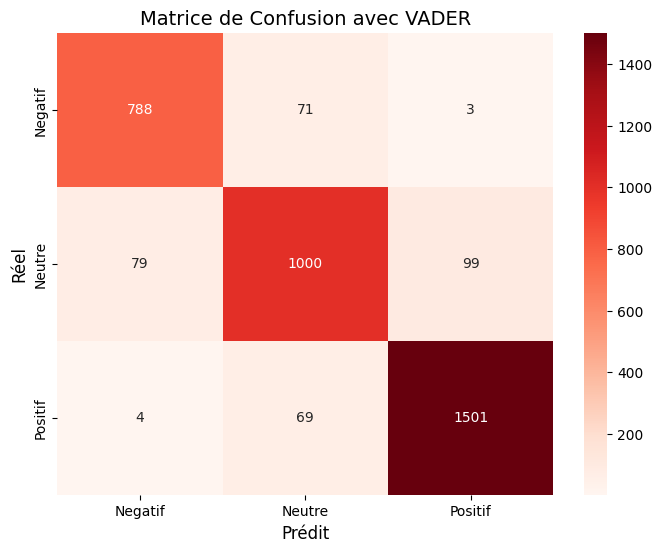

In [8]:
y_true = comments_df["Sentiments"]
y_pred = comments_df["Predicted_Sentiment"]

output_dir = "/content/Results"

# Calcul des métriques
accuracy = accuracy_score(y_true, y_pred) * 100  # Pourcentage
precision = precision_score(y_true, y_pred, average=None) * 100
recall = recall_score(y_true, y_pred, average=None) * 100

# Générer la matrice de confusion
labels = ["Negatif", "Neutre", "Positif"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)

# Titres et labels
plt.title("Matrice de Confusion avec VADER", fontsize=14)
plt.xlabel("Prédit", fontsize=12)
plt.ylabel("Réel", fontsize=12)

# Sauvegarde de la Matrice
confusion_matrix_path = os.path.join(output_dir, "confusion_matrix_VADER.png")
plt.savefig(confusion_matrix_path)
plt.show()

In [9]:
# Affichage des résultats
print(f"\n✅ Accuracy du modèle sur l'ensemble de test : {round(accuracy, 2)} %\n")
report = classification_report(y_true, y_pred)
print(report)


✅ Accuracy du modèle sur l'ensemble de test : 91.01 %

              precision    recall  f1-score   support

     Negatif       0.90      0.91      0.91       862
      Neutre       0.88      0.85      0.86      1178
     Positif       0.94      0.95      0.94      1574

    accuracy                           0.91      3614
   macro avg       0.91      0.91      0.91      3614
weighted avg       0.91      0.91      0.91      3614



## <span style="color: #E30613;">**7. Enregistrement des Résultats**</span>

In [10]:
metrics_path = os.path.join(output_dir, "metrics_results_VADER.txt")
annotated_csv_path = os.path.join(output_dir, "Annotated_Comments_VADER.csv")

with open(metrics_path, "w") as f:
    f.write(f"🔍 Évaluation des Sentiments\n")
    f.write("=" * 50 + "\n")
    f.write(f"\n✅ Accuracy du modèle sur l'ensemble de test : {round(accuracy, 2)} %\n\n")
    f.write(report)

# Sauvegarde du DataFrame annoté
comments_df.to_csv(annotated_csv_path, index=False)

print("\n✅ Annotation terminée !\n")


✅ Annotation terminée !



<h3 style="text-align: center; color: #E30613;"><b><i>Développé par: OUARAS Khelil Rafik</i></b></h3>